In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from my_rnn import MyRNN
from utils import load_normalization_metadata
from time import time
from numba import jit

plt.style.use('science')

In [ ]:

# Load normalization metadata
metadata_path = "Data/normalize_profiles/normalization_metadata.json"  # Adjust if located elsewhere
normalization_metadata = load_normalization_metadata(metadata_path)

# Load the trained model
model_path = "Data/model/best_model.pth"
model = MyRNN(
    RNN_type='LSTM',  # Match the architecture used during training
    nx=2,  # Input features (pressure and temperature)
    ny=1,  # Output feature (net flux)
    nx_sfc=0,
    nneur=(32, 32),  # Adjust based on training configuration
    outputs_one_longer=False,
    concat=False,
)
model.load_state_dict(torch.load(model_path))
model.eval()

# JIT-optimized functions for normalization and denormalization
@jit(nopython=True)
def normalize_min_max(data, global_min, global_max):
    return (data - global_min) / (global_max - global_min)

@jit(nopython=True)
def normalize_standard(data, mean, std):
    return (data - mean) / std

@jit(nopython=True)
def denormalize_standard(data, mean, std):
    return data * std + mean

# Normalize new data
def normalize_new_data(profile, normalization_metadata):
    """
    Normalize a new profile using stored metadata.
    """
    pressure_min = normalization_metadata["pressure"]["min"]
    pressure_max = normalization_metadata["pressure"]["max"]
    temperature_mean = normalization_metadata["temperature"]["mean"]
    temperature_std = normalization_metadata["temperature"]["std"]

    # Normalize pressure (log scale)
    pressure = np.log10(profile["pressure"])
    normalized_pressure = normalize_min_max(pressure, pressure_min, pressure_max)

    # Normalize temperature (standardized)
    temperature = np.array(profile["temperature"])
    normalized_temperature = normalize_standard(temperature, temperature_mean, temperature_std)

    # Combine inputs
    inputs = np.stack([normalized_pressure, normalized_temperature], axis=1)
    return torch.tensor(inputs, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Prediction Time: 0.00074 seconds
Prediction Time: 0.00072 seconds
Prediction Time: 0.00064 seconds
Prediction Time: 0.00047 seconds
Prediction Time: 0.00045 seconds


Text(0.5, 0, 'Temperature (K)')

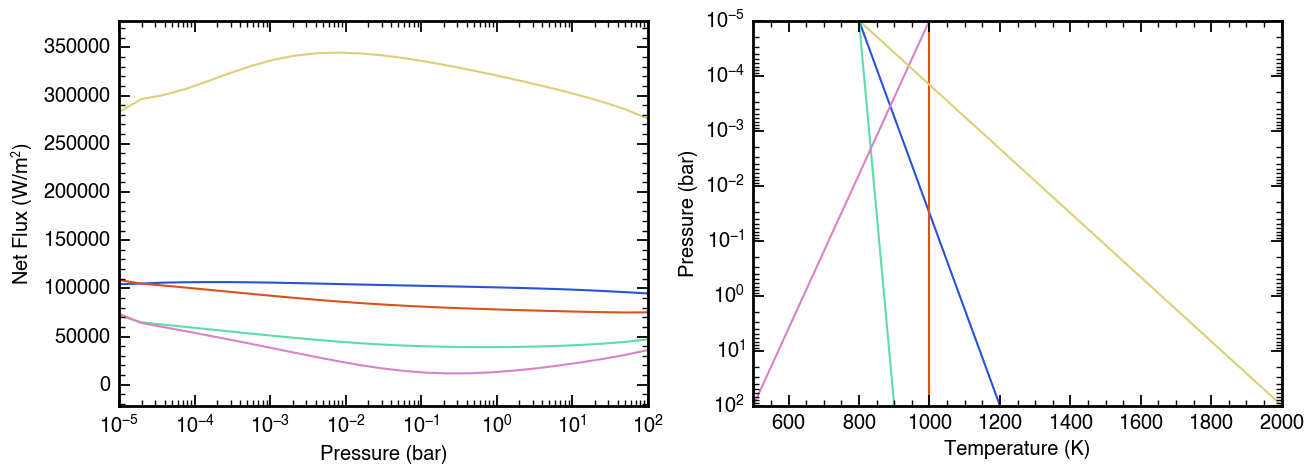

In [59]:
# Generate profiles with varying temperatures
num_layers = 25
profiles = []
pressures = list(np.logspace(-5, 2, num_layers))
temperature_profiles = [
    np.linspace(800, 1200, num_layers),
    np.linspace(1000, 1000, num_layers),  
    np.linspace(800, 900, num_layers),   
    np.linspace(1000, 500, num_layers),  
    np.linspace(800, 2000, num_layers)  
]

for temp_profile in temperature_profiles:
    profiles.append({"pressure": pressures, "temperature": temp_profile})

# Predict and visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for profile in profiles:
    normalized_inputs = normalize_new_data(profile, normalization_metadata)
    
    start_time = time()
    with torch.no_grad():
        predictions = model(inputs_main=normalized_inputs).squeeze(-1).numpy()
    elapsed_time = time() - start_time
    
    print(f"Prediction Time: {elapsed_time:.5f} seconds")

    # Denormalize predictions
    net_flux_mean = normalization_metadata["net_flux"]["mean"]
    net_flux_std = normalization_metadata["net_flux"]["std"]
    denormalized_predictions = denormalize_standard(predictions, net_flux_mean, net_flux_std)

    # Plot
    axes[0].plot(profile["pressure"], denormalized_predictions[0])
    axes[1].plot(profile["temperature"], profile["pressure"])

# Configure plots
axes[0].set_xscale('log')
axes[0].set_xlabel("Pressure (bar)")
axes[0].set_ylabel(r"Net Flux (W/m${^2}$)")
axes[0].legend()

axes[1].set_yscale('log')
axes[1].set_ylim(1e2, 1e-5)
axes[1].set_ylabel("Pressure (bar)")
axes[1].set_xlabel(r"Temperature (K)")